In [1]:
!pip install nltk pandas vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.5 MB/s eta 0:00:00


In [2]:
# Import libraries
import nltk
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
# Loading the dataset
try:
    df = pd.read_csv('Dallas_Airbnb.csv', nrows=4500)
except FileNotFoundError:
    print("Error: 'Dallas_Airbnb.csv' not found. Please upload the file or provide the correct path.")
    exit()

In [32]:
# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):  # Handling non-string values
        return ""
    tokens = nltk.word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(tokens)

In [5]:
# Applying preprocessing to the 'comments' column
df['processed_comments'] = df['comments'].astype(str).apply(preprocess_text)

# Remove top and bottom 5% terms by frequency
def remove_extreme_terms(text):
    words = text.split()
    if not words:
        return ""
    word_counts = Counter(words)
    total_words = len(words)
    top_n = int(0.05 * total_words)
    bottom_n = int(0.05 * total_words)
    most_common = [word for word, count in word_counts.most_common(top_n)]
    least_common = [word for word, count in word_counts.most_common()[:-bottom_n-1:-1]]
    filtered_words = [word for word in words if word not in most_common and word not in least_common]
    return " ".join(filtered_words)

df['processed_comments'] = df['processed_comments'].apply(remove_extreme_terms)

In [6]:
# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['processed_comments'].apply(lambda x: analyzer.polarity_scores(x))
df['compound_sentiment'] = df['sentiment_scores'].apply(lambda x: x['compound'])

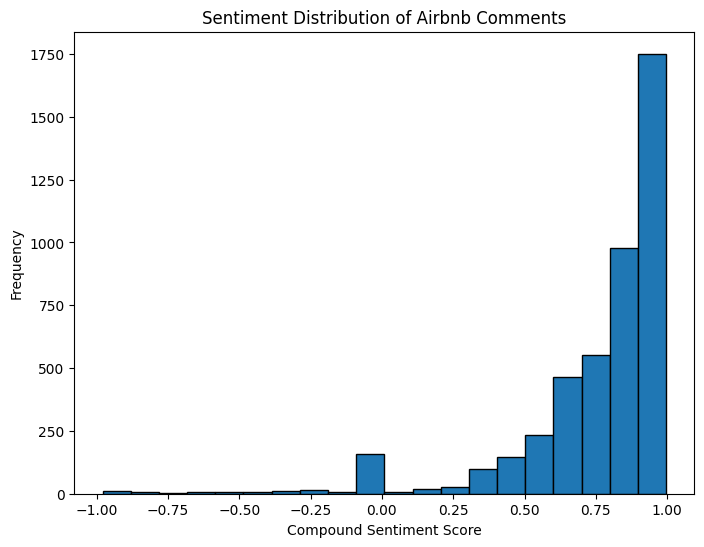

In [7]:
# Display sentiment distribution
plt.figure(figsize=(8, 6))
plt.hist(df['compound_sentiment'], bins=20, edgecolor='black')
plt.title('Sentiment Distribution of Airbnb Comments')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Get the top 5 best reviews and bottom 5 worst reviews
df_sorted = df.sort_values(by='compound_sentiment', ascending=False)
top_5_reviews = df_sorted.head(5)
bottom_5_reviews = df_sorted.tail(5)

print("Top 5 Best Reviews:")
print(top_5_reviews[['comments', 'compound_sentiment']])

print("\nBottom 5 Worst Reviews:")
print(bottom_5_reviews[['comments', 'compound_sentiment']])

Top 5 Best Reviews:
                                               comments  compound_sentiment
495   Tommy and Danielle were wonderful hosts! They ...              0.9965
1439  My stay at LlamaStay was nothing short of extr...              0.9956
4134  This is an amazing house from top to bottom! I...              0.9948
2101  First trip with my forever friends and this wa...              0.9933
3824  This AirBNB is superb. Entire house is newly r...              0.9928

Bottom 5 Worst Reviews:
                                               comments  compound_sentiment
4269  Upon first attempting to get into the apartmen...             -0.9056
1083  The worst Airbnb I’ve ever stayed in, but the ...             -0.9246
4200  Hard to be too mad since it's cheaper than mos...             -0.9371
2783  Place was just as horrible as the host. Yellow...             -0.9492
623   My stay was deeply disappointing, marking one ...             -0.9791


In [14]:
average_sentiment = df['compound_sentiment'].mean()
print(f"Average Sentiment Score: {average_sentiment}")

Average Sentiment Score: 0.7586888888888889


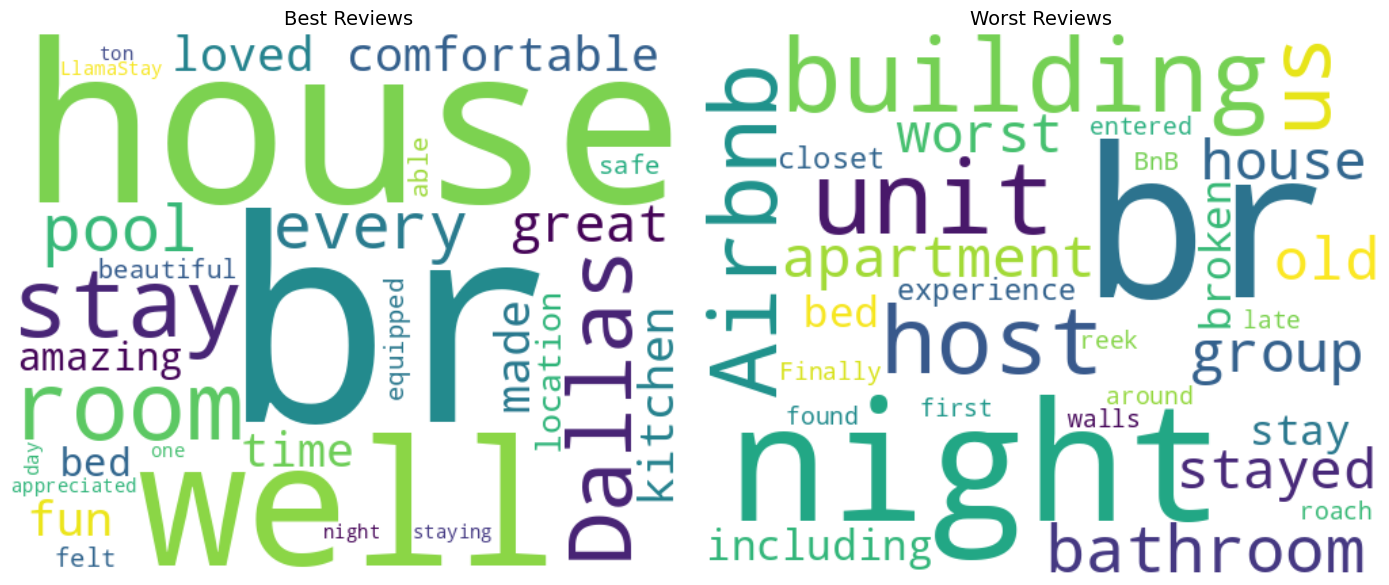

In [15]:
# Function to generate and display word clouds side by side with correct spacing
def plot_word_clouds(best_reviews, worst_reviews, max_words=30):
    # Combine reviews into single text for each group
    best_text = " ".join(best_reviews)
    worst_text = " ".join(worst_reviews)

    # Generate word clouds
    best_wordcloud = WordCloud(width=500, height=400, background_color='white', max_words=max_words).generate(best_text)
    worst_wordcloud = WordCloud(width=500, height=400, background_color='white', max_words=max_words).generate(worst_text)

    # Set up the figure with adjusted spacing
    plt.figure(figsize=(14, 6))  # Increase figure width for better spacing

    # Plot Best Reviews Word Cloud
    plt.subplot(1, 2, 1)
    plt.imshow(best_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Best Reviews", fontsize=14)

    # Plot Worst Reviews Word Cloud
    plt.subplot(1, 2, 2)
    plt.imshow(worst_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Worst Reviews", fontsize=14)

    # Adjust layout for better spacing
    plt.subplots_adjust(wspace=0.3)  # Add horizontal space between plots
    plt.tight_layout()
    plt.show()

# Convert comments to strings and handle potential errors
best_comments = top_5_reviews['comments'].astype(str).tolist()
worst_comments = bottom_5_reviews['comments'].astype(str).tolist()

# Generate and display the word clouds
plot_word_clouds(best_comments, worst_comments)

In [16]:
# displaying in detail for a comment how and why it is being labeled as neg, neu, pos

def analyze_sentiment_detail(comment):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(comment)

    print(f"Comment: {comment}")
    print(f"Negative: {scores['neg']:.3f}")
    print(f"Neutral: {scores['neu']:.3f}")
    print(f"Positive: {scores['pos']:.3f}")
    print(f"Compound: {scores['compound']:.3f}")

    if scores['compound'] >= 0.05:
        label = "Positive"
    elif scores['compound'] <= -0.05:
        label = "Negative"
    else:
        label = "Neutral"

    print(f"Overall Label: {label}")

    # Explanation of the labeling based on the VADER sentiment scores
    print("Explanation:")
    print("- The VADER lexicon assigns scores to individual words and phrases based on their emotional intensity.")
    print("- These individual scores are then aggregated to calculate the compound score, which represents the overall sentiment of the text.")
    print("- The negative, neutral, and positive scores represent the proportions of the text that express negative, neutral, and positive sentiment, respectively.")
    if label == 'Positive':
      print("- The compound score is above 0.05, indicating a predominantly positive sentiment.")
    elif label == 'Negative':
      print("- The compound score is below -0.05, indicating a predominantly negative sentiment.")
    else:
      print("- The compound score is between -0.05 and 0.05, indicating a neutral sentiment.")

# Example usage
# Select a few comments from your dataframe for detailed analysis
for index, row in df.head(3).iterrows():
  analyze_sentiment_detail(row['comments'])
  print("-" * 20)

Comment: Cute modern stay. Love the little touches throughout the home. Great communication with the host. Close to Bishop Arts area with cute eateries and shops. Would definitely recommend.
Negative: 0.000
Neutral: 0.530
Positive: 0.470
Compound: 0.961
Overall Label: Positive
Explanation:
- The VADER lexicon assigns scores to individual words and phrases based on their emotional intensity.
- These individual scores are then aggregated to calculate the compound score, which represents the overall sentiment of the text.
- The negative, neutral, and positive scores represent the proportions of the text that express negative, neutral, and positive sentiment, respectively.
- The compound score is above 0.05, indicating a predominantly positive sentiment.
--------------------
Comment: Very clean, well decorated and spacious Airbnb! We very much enjoyed our stay and the host Michelle was very communicative. Definitely recommend staying here!
Negative: 0.000
Neutral: 0.554
Positive: 0.446
Com

In [17]:
#displaying the column sentiment_score in the df

print(df['sentiment_scores'])

0       {'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'comp...
1       {'neg': 0.0, 'neu': 0.404, 'pos': 0.596, 'comp...
2       {'neg': 0.0, 'neu': 0.284, 'pos': 0.716, 'comp...
3       {'neg': 0.0, 'neu': 0.38, 'pos': 0.62, 'compou...
4       {'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'comp...
                              ...                        
4495    {'neg': 0.0, 'neu': 0.493, 'pos': 0.507, 'comp...
4496    {'neg': 0.0, 'neu': 0.333, 'pos': 0.667, 'comp...
4497    {'neg': 0.045, 'neu': 0.539, 'pos': 0.416, 'co...
4498    {'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp...
4499    {'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp...
Name: sentiment_scores, Length: 4500, dtype: object


In [33]:
#reading after addition of compound sentiment scores
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,id-1,listing_url,scrape_id,last_scraped,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,processed_comments,sentiment_scores,compound_sentiment,neg,neu,pos
0,53780147,736993546555370861,10/13/2022,349931594,Cynthia,Cute modern stay. Love the little touches thro...,53780147,https://www.airbnb.com/rooms/53780147,20240619201441,6/20/2024,...,1,0,0,4.68,modern stay love little touch throughout home ...,"{'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'comp...",0.9001,0.0,0.577,0.423
1,53780147,742817444594172048,10/21/2022,65077143,Ariana,"Very clean, well decorated and spacious Airbnb...",53780147,https://www.airbnb.com/rooms/53780147,20240619201441,6/20/2024,...,1,0,0,4.68,clean well decorated spacious airbnb much enjo...,"{'neg': 0.0, 'neu': 0.404, 'pos': 0.596, 'comp...",0.9062,0.0,0.404,0.596
2,53780147,744189228773388881,10/23/2022,464923665,Melissa,Great place to stay for our group of 5. Clean...,53780147,https://www.airbnb.com/rooms/53780147,20240619201441,6/20/2024,...,1,0,0,4.68,great place stay group clean modern comfortable,"{'neg': 0.0, 'neu': 0.284, 'pos': 0.716, 'comp...",0.8779,0.0,0.284,0.716
3,53780147,745709706504143766,10/25/2022,481406224,Gadiel,"Lovely place, clean spaces, it has everything ...",53780147,https://www.airbnb.com/rooms/53780147,20240619201441,6/20/2024,...,1,0,0,4.68,lovely place clean space everything need make ...,"{'neg': 0.0, 'neu': 0.38, 'pos': 0.62, 'compou...",0.8689,0.0,0.380,0.620
4,53780147,746397246342559430,10/26/2022,166360068,Richard,The rooftop lounging space was perfect. The ho...,53780147,https://www.airbnb.com/rooms/53780147,20240619201441,6/20/2024,...,1,0,0,4.68,rooftop lounging space perfect home spacious m...,"{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'comp...",0.9493,0.0,0.424,0.576


In [20]:
# Feature selection and model training
X = df[['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'host_total_listings_count', 'review_scores_accuracy', 'price', 'availability_365','compound_sentiment']]
y = df['review_scores_rating'].fillna(0)

# Impute missing values in X using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Feature selection
selector = SelectKBest(score_func=f_regression, k=5)
X_new = selector.fit_transform(X_imputed, y)

# Normalize data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_new)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [21]:
# Descriptive statistics for the target column 'review_scores_rating'
print(df['review_scores_rating'].describe())

count    4500.000000
mean        4.802367
std         0.187560
min         3.250000
25%         4.750000
50%         4.850000
75%         4.920000
max         5.000000
Name: review_scores_rating, dtype: float64


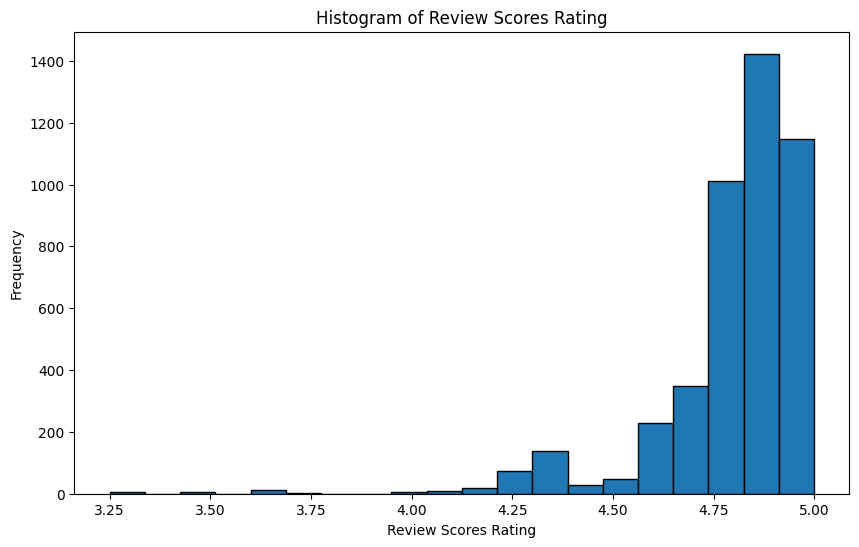

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(df['review_scores_rating'].dropna(), bins=20, edgecolor='black') # Drop NaN values for histogram
plt.title('Histogram of Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Frequency')
plt.show()

In [23]:
# Initialize models
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
lr = LinearRegression()
models = {'KNN': knn, 'Decision Tree': dt, 'Random Forest': rf, 'Linear Regression': lr}

In [24]:
# Train and evaluate models with detailed cross-validation output
results = []
for name, model in models.items():
    # Use KFold for more detailed cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
        cv_scores.append(mse_fold)
        print(f"Model: {name}, Fold: {fold + 1}, MSE: {mse_fold}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append([name, np.mean(cv_scores), mse, r2])
    print(f"Model: {name}, Mean CV MSE: {np.mean(cv_scores)}")

# Display results
results_df = pd.DataFrame(results, columns=['Model', 'Cross-Validation MSE', 'Test MSE', 'R-squared'])
results_df

Model: KNN, Fold: 1, MSE: 0.004427955555555556
Model: KNN, Fold: 2, MSE: 0.004991307936507936
Model: KNN, Fold: 3, MSE: 0.0031457523809523802
Model: KNN, Fold: 4, MSE: 0.005801282539682537
Model: KNN, Fold: 5, MSE: 0.006366755555555553
Model: KNN, Mean CV MSE: 0.004946610793650792
Model: Decision Tree, Fold: 1, MSE: 0.00030460317460317504
Model: Decision Tree, Fold: 2, MSE: 0.0013241269841269825
Model: Decision Tree, Fold: 3, MSE: 0.0020885714285714297
Model: Decision Tree, Fold: 4, MSE: 0.00037666666666666653
Model: Decision Tree, Fold: 5, MSE: 0.0008695238095238102
Model: Decision Tree, Mean CV MSE: 0.0009926984126984127
Model: Random Forest, Fold: 1, MSE: 0.00037191401587301443
Model: Random Forest, Fold: 2, MSE: 0.0007453004126983982
Model: Random Forest, Fold: 3, MSE: 0.0006934367301587239
Model: Random Forest, Fold: 4, MSE: 0.0008619010158730158
Model: Random Forest, Fold: 5, MSE: 0.0006916026349206373
Model: Random Forest, Mean CV MSE: 0.0006728309619047579
Model: Linear Regress

,Model,Cross-Validation MSE,Test MSE,R-squared
0,KNN,0.004947,0.003469,0.902623
1,Decision Tree,0.000993,0.001013,0.971557
2,Random Forest,0.000673,0.000885,0.975157
3,Linear Regression,0.006636,0.006332,0.822239


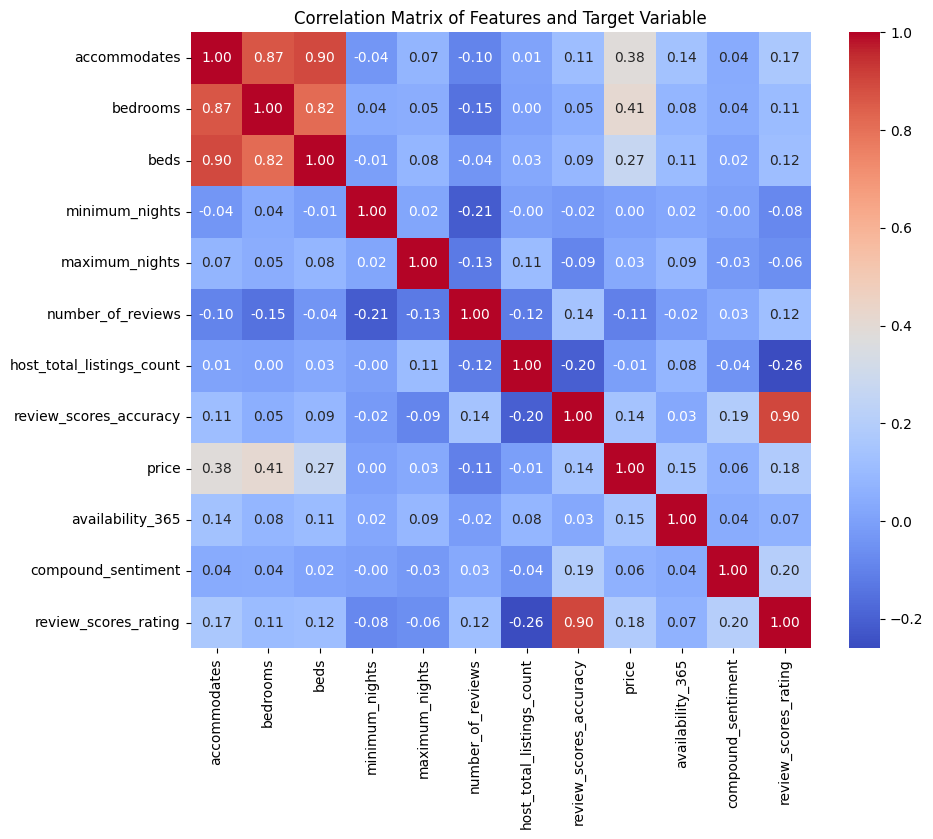

In [25]:
# Correlation matrix heatmap
correlation_matrix = pd.concat([X, y], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features and Target Variable')
plt.show()

      review_scores_rating  compound_sentiment
0                     4.91              0.9001
1                     4.91              0.9062
2                     4.91              0.8779
3                     4.91              0.8689
4                     4.91              0.9493
...                    ...                 ...
4495                  4.93              0.9073
4496                  4.93              0.9001
4497                  4.93              0.9652
4498                  4.76              0.5859
4499                  4.91              0.9535

[4500 rows x 2 columns]


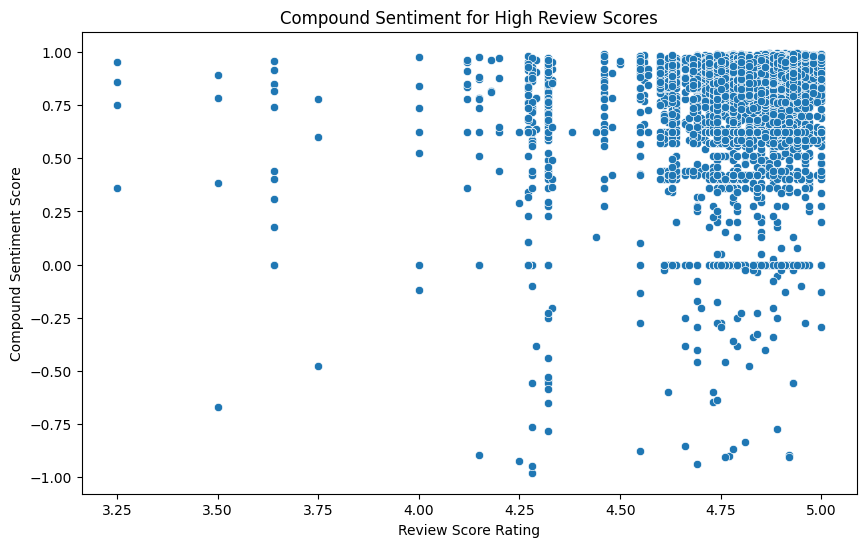

Correlation between review scores and sentiment: 0.2033040189275227


In [31]:
# Filter for high rating scores
high_rating_threshold = 2  # Example threshold, adjust as needed
high_rated_df = df[df['review_scores_rating'] >= high_rating_threshold]

# Display compound sentiment for high rating scores
print(high_rated_df[['review_scores_rating', 'compound_sentiment']])

# Visualization (optional)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_scores_rating', y='compound_sentiment', data=high_rated_df)
plt.title('Compound Sentiment for High Review Scores')
plt.xlabel('Review Score Rating')
plt.ylabel('Compound Sentiment Score')
plt.show()

# Calculate the correlation
correlation = df['review_scores_rating'].corr(df['compound_sentiment'])
print(f"Correlation between review scores and sentiment: {correlation}")